# Importing Dependencies

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os


# How Data Looks

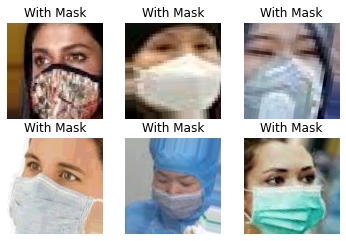

In [2]:
from os import listdir
listdir()
withmask='data/Train/WithMask'
train_images_NC=listdir(withmask)
plt.figure(figsize=(6,6))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(withmask,train_images_NC[i])),cmap='gray')
    plt.title('With Mask')
    plt.axis('off')
plt.show()

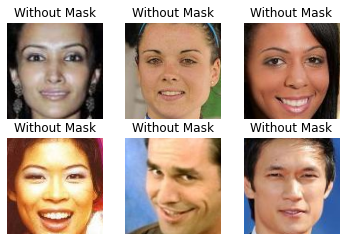

In [3]:
from os import listdir
listdir()
withoutmask='data/Train/WithoutMask'
train_images_NC=listdir(withoutmask)
plt.figure(figsize=(6,6))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(withoutmask,train_images_NC[i])),cmap='gray')
    plt.title('Without Mask')
    plt.axis('off')
plt.show()

**Image Counts**

In [4]:
total_train_with_mask = len(os.listdir('data/Train/WithMask'))
total_train_without_mask = len(os.listdir('data/Train/WithoutMask'))
total_test_with_mask = len(os.listdir('data/Test/WithMask'))
total_test_without_mask = len(os.listdir('data/Test/WithoutMask'))
total_val_with_mask = len(os.listdir('data/Validation/WithMask'))
total_val_without_mask = len(os.listdir('data/Validation/WithoutMask'))

print("Train sets images with mask: {}".format(total_train_with_mask))
print('--------------------------------------------')
print("Train sets images without mask: {}".format(total_train_without_mask))
print('--------------------------------------------')
print("Test sets images with mask: {}".format(total_test_with_mask))
print('--------------------------------------------')
print("Test sets images without mask: {}".format(total_test_without_mask))
print('--------------------------------------------')
print("Val sets images with mask: {}".format(total_val_with_mask))
print('--------------------------------------------')
print("Val sets images without mask: {}".format(total_val_without_mask))

Train sets images with mask: 5000
--------------------------------------------
Train sets images without mask: 5000
--------------------------------------------
Test sets images with mask: 483
--------------------------------------------
Test sets images without mask: 509
--------------------------------------------
Val sets images with mask: 400
--------------------------------------------
Val sets images without mask: 400


# Image Proccessing

In [5]:
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path='data/Train'
test_path = 'data/Test'
val_path = 'data/Validation'

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        seed = 42,
         class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
train_set.class_indices


{'WithoutMask': 0, 'WithMask': 1}

# After Proccessing

In [7]:
train_set

In [8]:
# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

# for i in range(4):
#     image = next(train_set)[0]
#     image = np.squeeze(image)
#     ax[i].imshow(image)
#     ax[i].axis('off')

# Model Building

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# MobileNetV2

In [10]:
mobilenet = MobileNetV2(input_shape=(224,224,3),weights = "imagenet", include_top = False)

for layer in mobilenet.layers:
    layer.trainable = False
    

model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilenet_history = model.fit(train_set,epochs=2,validation_data=val_set)

Epoch 1/2
313/313 [==============================] - 333s 1s/step - loss: 0.3904 - accuracy: 0.9726 - val_loss: 0.2033 - val_accuracy: 0.9900
Epoch 2/2
282/313 [==========================>...] - ETA: 25s - loss: 0.0854 - accuracy: 0.9926

**Plot**

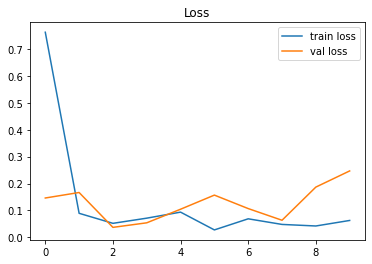

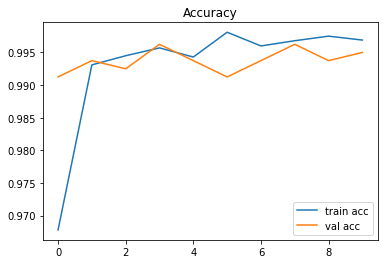

In [14]:
plt.plot(mobilenet_history.history['loss'], label='train loss')
plt.plot(mobilenet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(mobilenet_history.history['accuracy'], label='train acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

**Evaluation**

In [15]:
mobilenet_auc = model.evaluate(test_set)

31/31 [==============================] - 8s 269ms/step - loss: 0.2225 - accuracy: 0.9929


In [ ]:
model.save('mobile_net-2.h5')

[[0.00230164 0.99769837]]
No Mask Detected...Unsafe!!


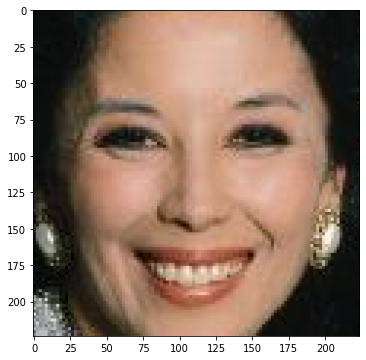

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
model = load_model('model_vgg19.h5')
img = image.load_img('data/Test/WithoutMask/3.png', target_size=(224, 224))

def prediction(img,model):
    # model = load_model('model_vgg19.h5')
    # img = image.load_img('val/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    print(classes)

    if classes[0][0]>0.5:
        pred= "Mask detected...Safe!!"
    else:
        pred= "No Mask Detected...Unsafe!!"

    return pred

pred= prediction(img,model)

print(pred)
plt.figure(figsize=(6,6))
plt.imshow(img)